In [1]:
import random
import seaborn as sns
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import matplotlib.pyplot as plt 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

SEED_VAL = 42

random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL);  # Semicolon prevents jupyter from displaying last line as output

D:\Python\Projects\Assistance\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SNIPS_PATH = "data/snips"
TRAIN_PATH = f"{SNIPS_PATH}/train.tsv"
VAL_PATH = f"{SNIPS_PATH}/dev.tsv"
TEST_PATH = f"{SNIPS_PATH}/test.tsv"
df = pd.read_csv(TEST_PATH,sep='\t')

def load_snips_file(file_path):
    list_pair =[]
    with open(file_path,'r',encoding="utf8") as f:
        for line in f:
            split_line = line.split('\t')
            pair = split_line[0],split_line[1]
            list_pair.append(pair)
    return list_pair


In [3]:
all_train_examples = load_snips_file(TRAIN_PATH)
valid_examples = load_snips_file(VAL_PATH)
test_examples = load_snips_file(TEST_PATH)

## Intent ID Lookup

In order to input the intent labels into our model we will need to **Create a dictionary mapping each intent name to an integer ID (starting with 0), and assign the dictionary to intent_labeltoid**.

In [4]:
intents = np.unique(np.array(all_train_examples)[:,0]).tolist()

intent_labeltoid = {intents[i]: i  for i in range(len(intents))}
intent_labeltoid

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [5]:
#How many training examples are there for each intent?
intent_series = pd.Series(np.array(all_train_examples)[:,0])
intent_series.value_counts()

PlayMusic               1914
GetWeather              1896
BookRestaurant          1881
RateBook                1876
SearchScreeningEvent    1852
SearchCreativeWork      1847
AddToPlaylist           1818
Name: count, dtype: int64

- The distribution of intents are uniform which each intents relatively having the same number of occurrence.
- This is not consistent with what we might expect in real life applications.

## Creating Mini-Training Sets



In [6]:
def create_mini_training_set(examples_per_intent):
    intent_array = np.array(all_train_examples)[:,0]
    mini_batch =[]
    for intent in intents:
        add = intent_array[intent_array==intent]
        shuffled_indicies=np.random.RandomState(seed=42).permutation(len(add))
        class_indicies=shuffled_indicies[:examples_per_intent]
        sampled_set = np.array(all_train_examples)[class_indicies]
        mini_batch.append(sampled_set)
    mini_batch = np.array(mini_batch)
    mini_set = mini_batch.transpose(1,0,2).reshape(-1,mini_batch.shape[2])
    return mini_set

In [7]:
def get_pad_length():
    all_train_examples_sentences = np.array(all_train_examples)[:,1]
    word_length = []
    for sentence in all_train_examples_sentences: 
        number_words = len(re.findall(r'\w+',sentence))
        word_length.append(number_words)
    return max(word_length)

PAD_LEN = get_pad_length() 

In [8]:
INTENT_DIM = 7

## BERT Tokenizer


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

test_utterance = "Alyssa told Ben the error of his ways"

print(tokenizer.encode_plus(
    test_utterance, add_special_tokens=True, max_length=PAD_LEN, padding='max_length',
    truncation=True, return_attention_mask=True, return_tensors='pt'
))

{'input_ids': tensor([[  101, 26442,  2409,  3841,  1996,  7561,  1997,  2010,  3971,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [10]:
def examples_to_dataset(examples):
    input_ids = []
    attention_masks = []
    labels = []
    for instance in examples:
        token_dict = tokenizer.encode_plus(
                instance[1], add_special_tokens=True, max_length=PAD_LEN, padding='max_length',
                truncation=True, return_attention_mask=True, return_tensors='pt')
        input_ids.append(token_dict['input_ids'])
        attention_masks.append(token_dict['attention_mask'])
        labels.append(torch.tensor(intent_labeltoid[instance[0]]).type(torch.long))
    
    input_ids = torch.cat(input_ids)
    attention_masks = torch.cat(attention_masks)
    labels = torch.stack(labels)
        

    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    return dataset

In [11]:
#prepare the validation/test dataloaders 
val_dataset = examples_to_dataset(valid_examples)
test_dataset = examples_to_dataset(test_examples)
BATCH_SIZE = 50
validation_dataloader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

# Training Setup

BERT will output a matrix tensor of shape batch size by #intents, which consists of the intent probabilities for each utterance in the batch. In order to compute the accuracy of the predictions, this prediction matrix is compared with the tensor of correct label IDs (a tensor of size #intents).



**The method `accuracy()`, which takes in the predictions (shape batch size by #intents) as a numpy array, and the correct labels as a numpy array (shape #intents), and returns the floating point accuracy of those predictions in the range \[0,1\]**

In [12]:
def get_accuracy(preds, labels):
    pred_convd = np.argmax(preds,1).flatten()
    labels_flat = labels.flatten()
    correct_labels = np.equal(pred_convd,labels_flat).sum()
    accuracy_value = correct_labels/len(labels)
    return accuracy_value

In [13]:
# Quick tests for the implementation of accuracy.

preds1 = np.array([[1,2,3], [1,3,2], [3,2,1]])

assert get_accuracy(preds1, np.array([2,1,0])) == 1.0
assert get_accuracy(preds1, np.array([2,2,0])) == 2/3
assert get_accuracy(preds1, np.array([3,2,1])) == 0.0

In [14]:
count = 0
for batch in tqdm(list(test_dataloader)):
    a,b,c= batch[0],batch[1],batch[2]
    count+=1
    if count ==1:
        break
print(a);print(b);print(c)
print(batch)
print(len(list(test_dataloader)))

  0%|          | 0/14 [00:00<?, ?it/s]

tensor([[  101,  5587, 21876,  ...,     0,     0,     0],
        [  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2404, 17518,  ...,     0,     0,     0],
        ...,
        [  101,  3446,  1996,  ...,     0,     0,     0],
        [  101,  2338,  1037,  ...,     0,     0,     0],
        [  101,  2338,  1037,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([0, 1, 0, 2, 3, 6, 1, 2, 6, 1, 6, 5, 6, 1, 5, 2, 5, 1, 6, 1, 4, 0, 0, 6,
        2, 2, 6, 1, 3, 0, 0, 4, 3, 6, 0, 5, 4, 6, 2, 2, 3, 4, 3, 2, 3, 2, 3, 4,
        1, 1])
[tensor([[  101,  5587, 21876,  ...,     0,     0,     0],
        [  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2404, 17518,  ...,     0,     0,     0],
        ...,
        [  101,  3446,  1996,  ...,     0,     0,     0],

In [15]:
def evaluate(model, dataloader):
    model.eval()

    accuracy = []

    for batch in tqdm(list(dataloader)):
        b_input_ids,b_input_mask,b_labels = batch
        
        
        with torch.no_grad():
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #logit_probability =torch.nn.Softmax(logits)
        batch_accuracy = get_accuracy(logits, label_ids)
        accuracy.append(batch_accuracy)
    avg_accuracy = np.mean(accuracy)  # TODO Compute final accuracy
    print("Validation Accuracy: {}".format(avg_accuracy))     
    return avg_accuracy      


- The input IDs, input mask, and labels are obtained from the dataloader. These inputs are passed through the model to get a prediction. After which the loss is computed for each batch.
- Thus the batch losses over time is monitored to compute the average training loss for each epoch. After every 5 batches,the validation accuracy is computed.

In [16]:

def train(model, epochs):
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8) 
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
   
    for epoch_i in range(0, EPOCHS):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

        model.train()
        #n_iteration = 0
        accuracy = []
        total_train_loss = []
        
        for step, batch in tqdm(list(enumerate(train_dataloader))):
            # get input IDs, input mask, and labels from batch
            b_input_ids,b_input_mask,b_labels = batch

            model.zero_grad()
            #pass inputs through model
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
              
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            # Add to total_train_loss
            total_train_loss.append(loss)
            #logit_probability =torch.nn.Softmax(logits)
            batch_accuracy = get_accuracy(logits, label_ids)
            accuracy.append(batch_accuracy)
            #n_iteration += 1
        # Compute average train loss
        new_loss = [x.cpu().detach().numpy() for x in total_train_loss]
        avg_train_loss = np.mean(new_loss) 
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Average Training accuracy: {0:.2f}".format(np.mean(accuracy)))
    #validation_accuracy =evaluate(bert_model, validation_dataloader)




By setting the number of epochs, and the number of examples per intent that will be for the mini-training set. The BERT model will be trained on that mini-training set for the specified number of epochs, and finally will be evaulated on the test set.

**The BERT model will be trained on each of the following values of `EXAMPLES_PER_INTENT`:** 1, 5, 10, 25, 50, 100, and 250. For each model, we will observe if the validation accuracy has converged to determine if the number of epochs needs to be increased and train again. 

In [28]:
BATCH_SIZE = 16

EPOCHS = 5
EXAMPLES_PER_INTENT = 250

mini_train_set = examples_to_dataset(create_mini_training_set(EXAMPLES_PER_INTENT))

train_dataloader = DataLoader(mini_train_set, sampler=RandomSampler(mini_train_set), batch_size=BATCH_SIZE)

bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = INTENT_DIM,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    use_safetensors=False
)

train(bert_model, EPOCHS)

print("Evaluating on test set:")
print("Test accuracy:", evaluate(bert_model, test_dataloader))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======== Epoch 1 / 5 ========


100%|██████████| 110/110 [01:43<00:00,  1.06it/s]


  Average training loss: 1.01
  Average Training accuracy: 0.75
======== Epoch 2 / 5 ========


100%|██████████| 110/110 [01:51<00:00,  1.01s/it]


  Average training loss: 0.10
  Average Training accuracy: 0.99
======== Epoch 3 / 5 ========


100%|██████████| 110/110 [01:40<00:00,  1.10it/s]


  Average training loss: 0.02
  Average Training accuracy: 1.00
======== Epoch 4 / 5 ========


100%|██████████| 110/110 [01:39<00:00,  1.11it/s]


  Average training loss: 0.01
  Average Training accuracy: 1.00
======== Epoch 5 / 5 ========


100%|██████████| 110/110 [01:44<00:00,  1.05it/s]


  Average training loss: 0.01
  Average Training accuracy: 1.00
Evaluating on test set:


100%|██████████| 14/14 [00:08<00:00,  1.68it/s]

Validation Accuracy: 0.9557142857142857
Test accuracy: 0.9557142857142857


In [29]:
# Test accuracy results per examples per intent

test_accuracies = {
    1: 0.27,
    5: 0.3157142857142857,
    10: 0.4471428571428572,
    25: 0.7314285714285715,
    50: 0.8471428571428571,
    100: 0.9500000000000001,
    250: 0.9614285714285715
}

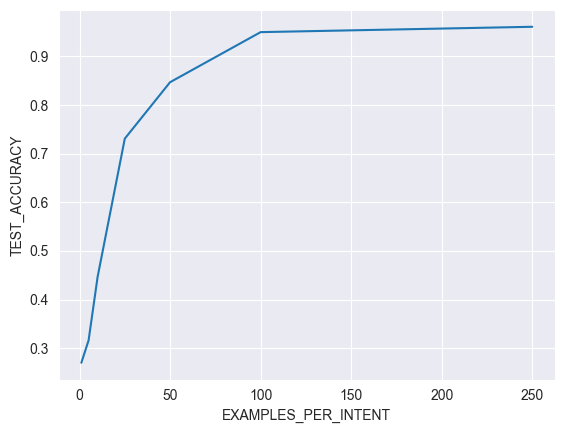

In [30]:
# A Plot of the final test accuracies as a function of EXAMPLES_PER_INTENT.

for accuracy in test_accuracies:
  test_accuracies[accuracy] = np.round(test_accuracies[accuracy],3)

ax = sns.lineplot(
    data=test_accuracies,
    x=list(test_accuracies.keys()), y=list(test_accuracies.values()),
    markers=True)
ax.set(xlabel='EXAMPLES_PER_INTENT', ylabel='TEST_ACCURACY')
plt.show()

In [31]:
# Save the trained model
output_dir = 'trained_model'
bert_model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

('trained_model\\tokenizer_config.json',
 'trained_model\\special_tokens_map.json',
 'trained_model\\vocab.txt',
 'trained_model\\added_tokens.json')